## Cancer Detection Project

### Introduction to problem and data

Cancer detection is a promising field for Convolutional Neural Networks. Diagnosing cancer currently is a manual process that requires a trained professional observing cells on a slide. As a result, especially in places without easy access to advanced medical care, cancer diagnoses can be lengthy processes that take time that could be used to provide treatment.

To improve this, if a neural network model could sit between the patient and the medical professional, it could provide a preliminary screen of cancer cells to allow the histopathologist to prioritize cases that had a high likelihood of being cancerous.

We will be building a model on the Histopathologic Cancer Detection Kaggle dataset, which contains 220025 32x32 pixel labelled images of either cancerous or non cancerous cells. The data comes pre cleaned and does not contain duplicates, and we know that only cancer cells near the center of the image cause the positive label.

Github Repo: https://github.com/Midelan/CancerDetectionKaggle/blob/main/CancerDetectionKaggle.ipynb

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow import keras
import keras_tuner
import scipy

2024-10-15 07:26:34.709464: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 07:26:34.714694: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 07:26:34.765426: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 07:26:34.823472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 07:26:34.877786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

### Exploratory Data Analysis

We first take a look at some of the sample images, and generate some summary statistics of the minimum, maximum, and average pixel "brightness" calculated as the sum of the RGB channels of each image.

Graphing these summary statistics we can see that the images provided have a fairly wide range of brightness, with the outliers of images with a high minimum brightness being almost all white and low maximum brightness being almost all black. There are a few outliers that are entirely white or black which we can exclude, as they are likely errors.

We also check the balance of the dataset, and see that there are substantially more cancerous cells than non-cancerous cells. This raises some concern for us as in the real world it is likely this model would mostly see non-cancerous cells, as screening tests can be run out of an abundance of caution. As such we do not want to bias the model towards cancer even more than if this distribution was representative.

Because of the low power of the computer this model needs to run on, we decide to solve the imbalance by sampling a random batch of 80,000 images from each class, which from tests was roughly the maximum the hardware could handle without crashing.

Finally we build a data generator to pull the images in from the csv image locations, which is set to standardize the images to the range of 0...1, by dividing each channel by 255, and to drop the 4th channel in the tif images as it is always 255 and provides no predictive power.

In [8]:
os.getcwd()
notebook_path = os.path.abspath("CancerDetectionKaggle.ipynb")
data_labels_path = os.path.join(os.path.dirname(notebook_path), "RawImports/train_labels.csv")
data = pd.read_csv(data_labels_path)

In [9]:
def getImageLoc(id):
    return os.path.join(os.path.dirname(notebook_path), "RawImports/train/"+id+".tif")

def getImageLocNoTif(id):
    return os.path.join(os.path.dirname(notebook_path), "RawImports/test/"+id)

def defineLabelText(label):
    if label == 0:
        return "positive"
    else:
        return "negative"

def getImage(loc):
    image = tf.io.read_file(loc)
    return tfio.experimental.image.decode_tiff(
        image
    )

def displayImageSample(df):
    row_headers = ["Positive Samples", "Negative Samples"]
    positive_sample = df[df["label"]==1].head().reset_index()
    negative_sample = df[df["label"]==0].head().reset_index()
    fig, axs = plt.subplots(2,5)
    for index, row in positive_sample.iterrows():
        img = getImage(row["image_loc"])
        axs[0, index].imshow(img)
    for index, row in negative_sample.iterrows():
        img = getImage(row["image_loc"])
        axs[1, index].imshow(img)
    for ax, row in zip(axs[:,0], ['Positive Samples', 'Negative Samples']):
        ax.set_ylabel(row)
    fig.tight_layout()
    plt.show()

def getImageValues(loc):
    tensor = getImage(loc)
    pixel_vals = np.sum(tensor[:,:,0:3], axis=2)/3
    minimum_pixel = np.min(pixel_vals)
    maximum_pixel = np.max(pixel_vals)
    average_pixel = np.mean(pixel_vals)
    return (minimum_pixel, maximum_pixel, average_pixel)

In [10]:
data["image_loc"] = data.apply(lambda x: getImageLoc(x['id']), axis=1)
data["descriptive_labels"] = data.apply(lambda x: defineLabelText(x['label']), axis=1)

In [11]:
data

,id,label,image_loc,descriptive_labels
0,f38a6374c348f90b587e046aac6079959adf3835,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/home/midelan/Workspace/Cancer Detection Kaggl...,negative
2,755db6279dae599ebb4d39a9123cce439965282d,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive
...,...,...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,/home/midelan/Workspace/Cancer Detection Kaggl...,negative
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive


I0000 00:00:1728888980.712204  421901 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-14 02:56:20.712798: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-14 02:56:20.761400: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA


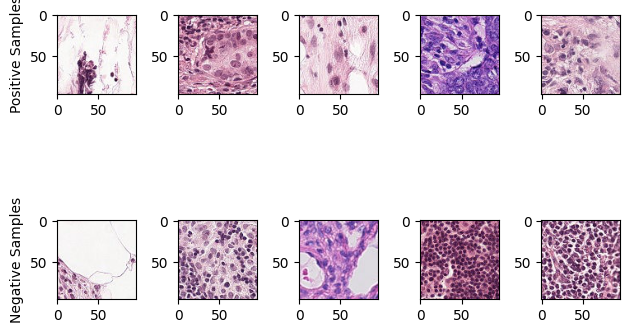

In [6]:
displayImageSample(data)

In [17]:
getImageValues(data.iloc[0]["image_loc"])
data[["minimum", "maximum", "average"]] = data.apply(lambda x: getImageValues(x['image_loc']), axis=1, result_type='expand')

In [7]:
data

,id,label,image_loc,descriptive_labels,minimum,maximum,average
0,f38a6374c348f90b587e046aac6079959adf3835,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,16.333333,255.000000,232.890119
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/home/midelan/Workspace/Cancer Detection Kaggl...,negative,6.333333,255.000000,226.555773
2,755db6279dae599ebb4d39a9123cce439965282d,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,16.000000,254.000000,172.537435
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,52.333333,253.666667,179.904695
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,8.333333,254.000000,115.152814
...,...,...,...,...,...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,10.000000,255.000000,172.248770
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,/home/midelan/Workspace/Cancer Detection Kaggl...,negative,11.333333,255.000000,221.845161
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,8.333333,253.333333,99.354384
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,9.333333,254.000000,123.654803


In [ ]:
print("Max minimum pixel")
print(data["minimum"].max())
print("Min maximum pixel")
print(data["maximum"].min())
data[["minimum","maximum","average"]].boxplot()

<Axes: xlabel='descriptive_labels'>

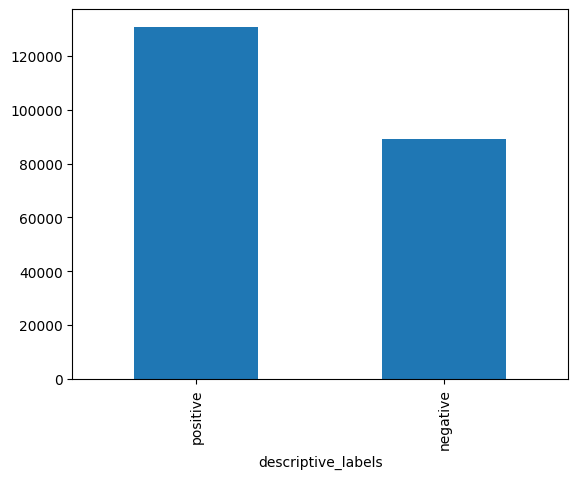

In [10]:
data["descriptive_labels"].value_counts().plot(kind="bar")

In [18]:
data = data.drop(data[data.minimum == 255].index)
data = data.drop(data[data.maximum == 0].index)
data_subsample = data.groupby('descriptive_labels', group_keys=False).apply(lambda x: x.sample(80000))
data_subsample

/tmp/ipykernel_2467756/3615821505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_subsample = data.groupby('descriptive_labels', group_keys=False).apply(lambda x: x.sample(80000))


,id,label,image_loc,descriptive_labels,minimum,maximum,average
65056,c89bc711f44d10418be068eb9ef4a49cf9cb1085,1,/home/midelan/Workspace/Cancer Detection Kaggl...,negative,39.666667,251.333333,176.960214
185108,60383186855d8583a563ccf8b49e2150e6ba63d4,1,/home/midelan/Workspace/Cancer Detection Kaggl...,negative,23.000000,250.000000,151.427264
190258,a1335429f6a95a0732f4739bb8fc23d1a5a5163d,1,/home/midelan/Workspace/Cancer Detection Kaggl...,negative,25.666667,244.666667,130.864837
63699,8520ce871520c27868f5ff225ac7814eac8a5d39,1,/home/midelan/Workspace/Cancer Detection Kaggl...,negative,32.000000,250.666667,144.567383
68542,73a5aebea2a8ac12c643b1a39b4b23ac658201ef,1,/home/midelan/Workspace/Cancer Detection Kaggl...,negative,8.666667,253.000000,154.226997
...,...,...,...,...,...,...,...
83658,65099bb363a0d630c28b7819a02c2e4cf2fe240e,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,11.333333,254.000000,156.380281
140088,7575873640b29b7ee0e310e75e6a0f07e99ece2e,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,9.000000,255.000000,202.779369
64369,5f059d0c4c0722434a87ef5a51bf3eeb0e4b00c7,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,6.666667,254.333333,147.408709
194235,23649768eeda1f316ca2eca8faf6093c0ad565b9,0,/home/midelan/Workspace/Cancer Detection Kaggl...,positive,13.333333,240.666667,83.210069


Max minimum pixel
248.33333333333334
Min maximum pixel
26.0


<Axes: >

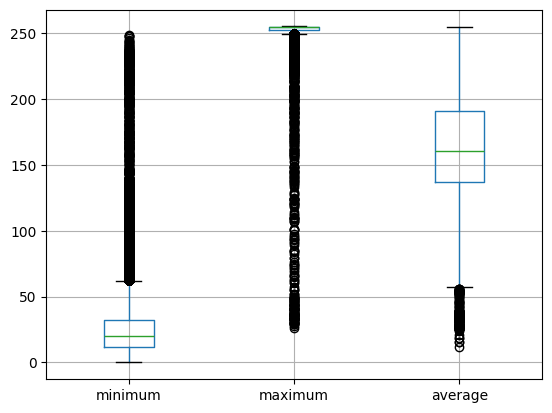

In [19]:
print("Max minimum pixel")
print(data_subsample["minimum"].max())
print("Min maximum pixel")
print(data_subsample["maximum"].min())
data_subsample[["minimum","maximum","average"]].boxplot()

<Axes: xlabel='descriptive_labels'>

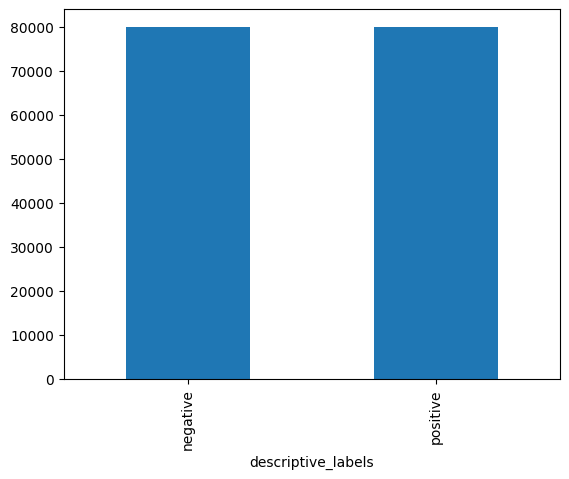

In [13]:
data_subsample["descriptive_labels"].value_counts().plot(kind="bar")

In [20]:
generator = image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_flow = generator.flow_from_dataframe(dataframe=data_subsample, x_col="image_loc", y_col="descriptive_labels", batch_size =1)

Found 160000 validated image filenames belonging to 2 classes.


In [15]:
img = getImage(data_subsample.iloc[0]["image_loc"])
print(img)

tf.Tensor(
[[[216 201 204 255]
  [249 234 237 255]
  [197 182 189 255]
  ...
  [234 211 231 255]
  [255 227 254 255]
  [129  92 123 255]]

 [[246 226 228 255]
  [251 232 236 255]
  [242 223 229 255]
  ...
  [218 193 212 255]
  [231 199 223 255]
  [212 173 202 255]]

 [[231 204 209 255]
  [242 215 222 255]
  [168 143 149 255]
  ...
  [255 235 251 255]
  [230 197 218 255]
  [217 179 204 255]]

 ...

 [[137  72 115 255]
  [162  99 142 255]
  [141  80 124 255]
  ...
  [121  74 110 255]
  [ 71  23  65 255]
  [207 157 206 255]]

 [[159  98 131 255]
  [176 116 152 255]
  [154  96 134 255]
  ...
  [ 68  23  54 255]
  [100  54  93 255]
  [252 205 251 255]]

 [[169 109 137 255]
  [166 107 137 255]
  [213 156 189 255]
  ...
  [189 146 174 255]
  [138  94 130 255]
  [163 118 161 255]]], shape=(96, 96, 4), dtype=uint8)


In [21]:
train_generator = generator.flow_from_dataframe(
    dataframe=data_subsample,
    target_size=(96, 96),
    x_col="image_loc", 
    y_col="descriptive_labels",
    class_mode='binary',
    subset='training',
    batch_size=2560)

validate_generator = generator.flow_from_dataframe(
    dataframe=data_subsample,
    target_size=(96, 96),
    x_col="image_loc", 
    y_col="descriptive_labels",
    class_mode='binary',
    subset='validation',
    batch_size=3200)

Found 128000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.


### Exploratory Data Analysis

There are four models we want to build for our preliminary testing, but each is comprised of the same basic blocks:

An input layer the size of the inbound images.
A set of Conv2D - MaxPooling2D layers to perform the convolution on the image and extract features.
A series of Dense - Dropout layers to evaluate the features, with dropouts included to prevent overfitting.
A one element Dense layer as the output, with sigmoid activation as we are performing binary classification.

Our baseline model is simply two convolutional blocks followed by a dense block.

The extended convolution model uses four convolution blocks instead of the two in the baseline model.

The extended dense model uses two dense blocks instead of the one in the baseline model.

And the doubled convolution model includes two Conv2D layers between each MaxPooling Layer.

Each model is run against validation data, and we see that there are indications of overfitting in the latter two models as the test loss substantially increases at the end of the training, however the extended convolution model seems to still be improving, and have a better accuracy than the baseline at the end of the training, so that is the model we decide to proceed with.

In [41]:
baseline_model = keras.Sequential([
    tf.keras.layers.Input(shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

baseline_history = baseline_model.fit(train_generator, 
                                validation_data = validate_generator,
                                epochs = 25,
                                verbose = 1,
                                callbacks=[callback])

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.6073 - loss: 0.7116 - val_accuracy: 0.0644 - val_loss: 1.0331
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7140 - loss: 0.5307 - val_accuracy: 0.5807 - val_loss: 0.8589
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.7883 - loss: 0.4953 - val_accuracy: 0.6968 - val_loss: 0.7103
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.7940 - loss: 0.4739 - val_accuracy: 0.7713 - val_loss: 0.4918
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8022 - loss: 0.4419 - val_accuracy: 0.5871 - val_loss: 0.7912
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8054 - loss: 0.4323 - val_accuracy: 0.5781 - val_loss: 0.8109
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8114 - loss: 0.4232 - val_accuracy: 0.6111 - val_loss: 0.7591
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8155 - loss: 0.4169 - val_accuracy: 0.7132 - v

2024-10-15 04:14:09.522911: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 353907200 bytes after encountering the first element of size 353907200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8344 - loss: 0.3831 - val_accuracy: 0.7215 - val_loss: 0.5799
Epoch 13/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8416 - loss: 0.3660 - val_accuracy: 0.6895 - val_loss: 0.6406
Epoch 14/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8470 - loss: 0.3595 - val_accuracy: 0.8484 - val_loss: 0.3314
Epoch 15/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8438 - loss: 0.3656 - val_accuracy: 0.7209 - val_loss: 0.5875
Epoch 16/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8532 - loss: 0.3438 - val_accuracy: 0.6828 - val_loss: 0.6906
Epoch 17/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8590 - loss: 0.3316 - val_accuracy: 0.7208 - val_loss: 0.5691
Epoch 18/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8639 - loss: 0.3243

2024-10-15 04:24:46.291036: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 353907200 bytes after encountering the first element of size 353907200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


50/50 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8638 - loss: 0.3244 - val_accuracy: 0.7397 - val_loss: 0.5509
Epoch 19/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8681 - loss: 0.3173 - val_accuracy: 0.8324 - val_loss: 0.3639
Epoch 20/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8681 - loss: 0.3140 - val_accuracy: 0.8047 - val_loss: 0.4219
Epoch 21/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8737 - loss: 0.3021 - val_accuracy: 0.7665 - val_loss: 0.4934
Epoch 22/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8825 - loss: 0.2853 - val_accuracy: 0.7292 - val_loss: 0.6118
Epoch 23/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8747 - loss: 0.3010 - val_accuracy: 0.7252 - val_loss: 0.5895
Epoch 24/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8868 - loss: 0.2765 - val_accuracy: 0.7298 - val_loss: 0.6192
Epoch 25/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8900 - loss: 0.2677

2024-10-15 04:36:39.935155: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 353907200 bytes after encountering the first element of size 353907200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


50/50 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8900 - loss: 0.2677 - val_accuracy: 0.7731 - val_loss: 0.5334


In [18]:
np.save(os.path.join(os.path.dirname(notebook_path), "save_models/baseline_history.npy"),baseline_history)
baseline_model.save(os.path.join(os.path.dirname(notebook_path), "save_models/baseline.keras"))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [19]:
extended_convolution_model = keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

extended_convolution_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

extended_convolution_history = extended_convolution_model.fit(train_generator, 
                                validation_data = validate_generator,
                                epochs = 25,
                                verbose = 1,
                                callbacks=[callback])

/home/midelan/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6484 - loss: 0.6227 - val_accuracy: 0.7627 - val_loss: 0.5733
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7885 - loss: 0.4729 - val_accuracy: 0.7372 - val_loss: 0.5749
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7969 - loss: 0.4558 - val_accuracy: 0.6660 - val_loss: 0.6793
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8014 - loss: 0.4444 - val_accuracy: 0.7580 - val_loss: 0.5224
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8066 - loss: 0.4359 - val_accuracy: 0.8252 - val_loss: 0.3970
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8068 - loss: 0.4300 - val_accuracy: 0.7813 - val_loss: 0.4611
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8173 - loss: 0.4126 - val_accuracy: 0.7891 - val_loss: 0.4470
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8237 - loss: 0.3982 - val_accuracy: 0.7386 - val_loss:

In [20]:
np.save(os.path.join(os.path.dirname(notebook_path), "save_models/extended_convolution_history.npy"),extended_convolution_history)
extended_convolution_model.save(os.path.join(os.path.dirname(notebook_path), "save_models/extended_convolution.keras"))

In [21]:
extended_dense_model = keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

extended_dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

extended_dense_history = extended_dense_model.fit(train_generator, 
                                validation_data = validate_generator,
                                epochs = 25,
                                verbose = 1,
                                callbacks=[callback])

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5973 - loss: 0.6670 - val_accuracy: 0.3725 - val_loss: 0.8884
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7566 - loss: 0.5347 - val_accuracy: 0.6277 - val_loss: 0.8063
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7915 - loss: 0.5061 - val_accuracy: 0.6498 - val_loss: 0.7279
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7989 - loss: 0.4676 - val_accuracy: 0.6447 - val_loss: 0.6356
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8037 - loss: 0.4479 - val_accuracy: 0.7265 - val_loss: 0.5103
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8140 - loss: 0.4273 - val_accuracy: 0.7277 - val_loss: 0.5002
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8202 - loss: 0.4169 - val_accuracy: 0.7706 - val_loss: 0.4434
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8199 - loss: 0.4166 - val_accuracy: 0.6857 - val_loss:

In [22]:
np.save(os.path.join(os.path.dirname(notebook_path), "save_models/extended_dense_history.npy"),extended_dense_history)
extended_dense_model.save(os.path.join(os.path.dirname(notebook_path), "save_models/extended_dense.keras"))

In [23]:
doubled_convolution_model = keras.Sequential([
    tf.keras.layers.Input(shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

doubled_convolution_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

doubled_convolution_history = doubled_convolution_model.fit(train_generator, 
                                validation_data = validate_generator,
                                epochs = 25,
                                verbose = 1,
                                callbacks=[callback])

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5476 - loss: 1.8969 - val_accuracy: 0.0000e+00 - val_loss: 0.8931
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6485 - loss: 0.5666 - val_accuracy: 0.5835 - val_loss: 0.9344
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7518 - loss: 0.5497 - val_accuracy: 0.6707 - val_loss: 0.8738
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7672 - loss: 0.5331 - val_accuracy: 0.6283 - val_loss: 0.9363
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7701 - loss: 0.5280 - val_accuracy: 0.7706 - val_loss: 0.7585
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7750 - loss: 0.5197 - val_accuracy: 0.6620 - val_loss: 0.8157
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7858 - loss: 0.5114 - val_accuracy: 0.6779 - val_loss: 0.8868
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7956 - loss: 0.4993 - val_accuracy: 0.5712

In [24]:
np.save(os.path.join(os.path.dirname(notebook_path), "save_models/doubled_convolution_history.npy"),doubled_convolution_history)
doubled_convolution_model.save(os.path.join(os.path.dirname(notebook_path), "save_models/doubled_convolution.keras"))

In [15]:
baseline_model = keras.models.load_model(os.path.join(os.path.dirname(notebook_path), "save_models/baseline.keras"))
extended_convolution_model = keras.models.load_model(os.path.join(os.path.dirname(notebook_path), "save_models/extended_convolution.keras"))
extended_dense_model = keras.models.load_model(os.path.join(os.path.dirname(notebook_path), "save_models/extended_dense.keras"))
doubled_convolution_model = keras.models.load_model(os.path.join(os.path.dirname(notebook_path), "save_models/doubled_convolution.keras"))
baseline_history = np.load(str(os.path.join(os.path.dirname(notebook_path), "save_models/baseline_history.npy")),allow_pickle=True)
extended_convolution_history = np.load(str(os.path.join(os.path.dirname(notebook_path), "save_models/extended_convolution_history.npy")),allow_pickle=True)
extended_dense_history = np.load(str(os.path.join(os.path.dirname(notebook_path), "save_models/extended_dense_history.npy")),allow_pickle=True)
doubled_convolution_history = np.load(str(os.path.join(os.path.dirname(notebook_path), "save_models/doubled_convolution_history.npy")),allow_pickle=True)

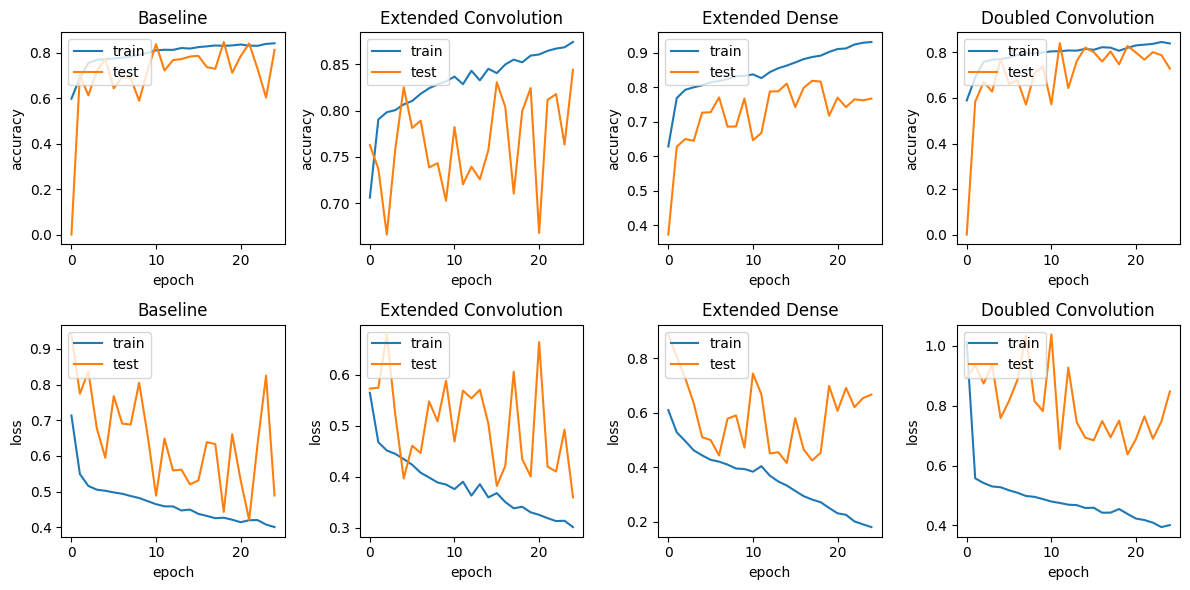

In [28]:
fig, axs = plt.subplots(2,4,figsize=(12, 6))
histories = [baseline_history,extended_convolution_history,extended_dense_history,doubled_convolution_history]
names = ["Baseline","Extended Convolution","Extended Dense","Doubled Convolution","Combined"]
index = 0
for history in histories:
    ax = axs[0,index]
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.title.set_text(names[index])
    ax.set(xlabel='epoch', ylabel='accuracy')
    ax.legend(['train', 'test'], loc='upper left')
    index = index+1

index = 0
for history in histories:
    ax = axs[1,index]
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.title.set_text(names[index])
    ax.set(xlabel='epoch', ylabel='loss')
    ax.legend(['train', 'test'], loc='upper left')
    index = index+1
plt.tight_layout()
plt.show()

### Results and Analysis

We want to tune the number of elements in each layer, as well as the dropout rate and the learning rate, so we configure each as a hyperparameter and pass it to the Keras tuner. Taking the newly tuned hyperparameters we can retrain our preferred model using the new parameters.

We see that with the new parameters we achieve an accuracy similar to the extended convolution model initially, but the loss curve appears to be continuing to decrease, indicating that we are not yet overfitting on the train set, so we believe this is an acceptable initial model. 

Hyperparameters are provided in the table below, and we believe that the learning rate was likely the most significant improvement, along with the increased dropout rate, as they may be improving the overfitting we were seeing before.

In [27]:
def model_builder(params):
    tuned_model = keras.Sequential([
        tf.keras.layers.Input(shape=(96, 96, 3)),
        tf.keras.layers.Conv2D(params.Int("units_1", min_value=16, max_value=64, step=16), (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(params.Int("units_2", min_value=16, max_value=64, step=16), (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(params.Int("units_3", min_value=16, max_value=64, step=16), (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(params.Int("units_4", min_value=16, max_value=64, step=16), (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(params.Int("units_5", min_value=16, max_value=64, step=16), activation='relu'),
        tf.keras.layers.Dropout(params.Float("do_2", min_value=0.1, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    tuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=params.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")), loss='binary_crossentropy', metrics=["accuracy"])
    
    return tuned_model

In [23]:
tuner = keras_tuner.RandomSearch(
    hypermodel=model_builder,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="models",
    project_name="cancer_detection",
)

In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
do_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [25]:
tuner.search(train_generator, epochs=2, validation_data=validate_generator)

Trial 3 Complete [00h 08m 28s]
val_accuracy: 0.762499988079071

Best val_accuracy So Far: 0.762499988079071
Total elapsed time: 00h 27m 05s


In [28]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

/home/midelan/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 48)     │        27,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 48)       │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,177 (399.13 KB)

 Trainable params: 102,177 (399.13 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
best_hps = tuner.get_best_hyperparameters(1)
final_model = model_builder(best_hps[0])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

final_model_history = final_model.fit(train_generator, 
                                validation_data = validate_generator,
                                epochs = 20,
                                verbose = 1,
                                callbacks=[callback])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 280s 6s/step - accuracy: 0.6258 - loss: 0.6409 - val_accuracy: 0.5555 - val_loss: 0.9853
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.7787 - loss: 0.4931 - val_accuracy: 0.6491 - val_loss: 0.6631
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 278s 6s/step - accuracy: 0.7945 - loss: 0.4621 - val_accuracy: 0.6953 - val_loss: 0.6064
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step - accuracy: 0.8012 - loss: 0.4523 - val_accuracy: 0.5713 - val_loss: 0.7457
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.8046 - loss: 0.4421 - val_accuracy: 0.7115 - val_loss: 0.5624
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 276s 6s/step - accuracy: 0.8101 - loss: 0.4339 - val_accuracy: 0.6961 - val_loss: 0.5821
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step - accuracy: 0.8110 - loss: 0.4287 - val_accuracy: 0.7061 - val_loss: 0.5569
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step - accuracy: 0.8158 - loss: 0.4212 - val_accuracy: 0.6348 - v

2024-10-14 11:03:11.051759: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 353907200 bytes after encountering the first element of size 353907200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


50/50 ━━━━━━━━━━━━━━━━━━━━ 278s 6s/step - accuracy: 0.8216 - loss: 0.4123 - val_accuracy: 0.7301 - val_loss: 0.5141
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 278s 6s/step - accuracy: 0.8262 - loss: 0.4045 - val_accuracy: 0.7172 - val_loss: 0.5286
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step - accuracy: 0.8271 - loss: 0.4046 - val_accuracy: 0.7932 - val_loss: 0.4248
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 280s 6s/step - accuracy: 0.8357 - loss: 0.3880 - val_accuracy: 0.6993 - val_loss: 0.5687
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.8345 - loss: 0.3891 - val_accuracy: 0.7364 - val_loss: 0.5145
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 284s 6s/step - accuracy: 0.8416 - loss: 0.3724 - val_accuracy: 0.7064 - val_loss: 0.5602
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 286s 6s/step - accuracy: 0.8408 - loss: 0.3741 - val_accuracy: 0.8345 - val_loss: 0.3386
Epoch 16/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 286s 6s/step - accuracy: 0.8460 - loss: 0.3664 - val_accuracy: 0.7133 - val_l

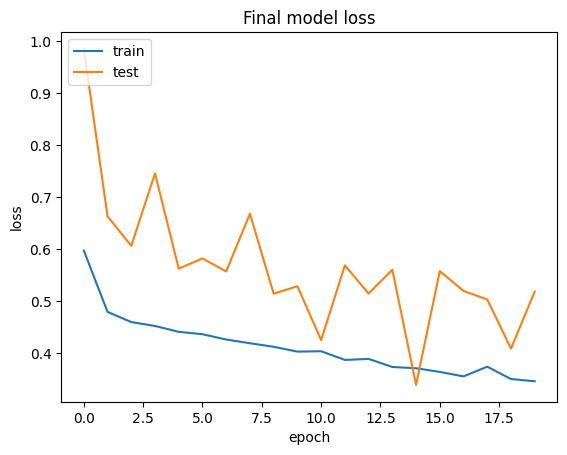

In [17]:
plt.plot(final_model_history.history['loss'])
plt.plot(final_model_history.history['val_loss'])
plt.title('Final model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

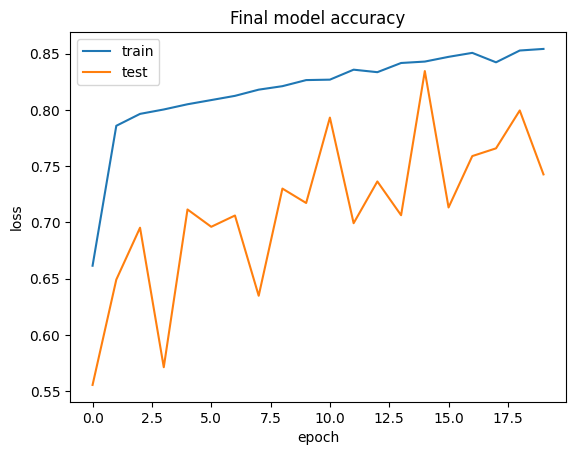

In [18]:
plt.plot(final_model_history.history['accuracy'])
plt.plot(final_model_history.history['val_accuracy'])
plt.title('Final model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
np.save(os.path.join(os.path.dirname(notebook_path), "save_models/final_history.npy"),final_model_history)
final_model.save(os.path.join(os.path.dirname(notebook_path), "save_models/final.keras"))

In [31]:
best_hps[0].values

{'units_1': 48,
 'units_2': 64,
 'units_3': 48,
 'units_4': 48,
 'units_5': 32,
 'do_2': 0.30000000000000004,
 'lr': 0.001317942267020829}

In [21]:
def remove_tif(image):
    return image[:-4]

In [22]:
test_list = os.listdir(os.path.join(os.path.dirname(notebook_path), "RawImports/test"))
test_df = pd.DataFrame(test_list, columns=['image_loc'])
test_df["id"] = test_df.apply(lambda x: remove_tif(x['image_loc']), axis=1)
test_df["image_loc"] = test_df.apply(lambda x: getImageLocNoTif(x['image_loc']), axis=1)

In [23]:
test_df

,image_loc,id
0,/home/midelan/Workspace/Cancer Detection Kaggl...,98b127f229617385717aa14935a45313e5bab6c0
1,/home/midelan/Workspace/Cancer Detection Kaggl...,8ed92845fff4aac2dbb7b5c93c0b34fcc16e290a
2,/home/midelan/Workspace/Cancer Detection Kaggl...,a65930b04b36e6fdad57afc59125972d2d01978a
3,/home/midelan/Workspace/Cancer Detection Kaggl...,8bde1eae6c2d5a93768b8f6a8fe42daec694e011
4,/home/midelan/Workspace/Cancer Detection Kaggl...,447a93b291b084f6acdfcbf1bd8a7d63530e2fdd
...,...,...
57453,/home/midelan/Workspace/Cancer Detection Kaggl...,3d34c62df2ad457788f9830a0ebf04b557c16bbe
57454,/home/midelan/Workspace/Cancer Detection Kaggl...,f8c1d80a174cbb39d25265e4561433d5904f0440
57455,/home/midelan/Workspace/Cancer Detection Kaggl...,9afcc91c6d8919ce1fdebe1ff80246d6dc7a4408
57456,/home/midelan/Workspace/Cancer Detection Kaggl...,2c61a1ba924c47b7faeaa570773a7eadc811026a


In [24]:
final_model = tf.keras.models.load_model(os.path.join(os.path.dirname(notebook_path), "save_models/extended_dense.keras"))

In [25]:
# Would have liked to use a generator as for test/train, but there is a known bug where it was producing incompatible records for test data
def predict_row(image_location):
    image = getImage(image_location).numpy()[:,:,0:3]/255
    image = image[np.newaxis, :] 
    prediction = final_model.predict(image, verbose=0)
    if prediction >= 0.5:
        return 1
    else:
        return 0

In [26]:
test_df["label"] = test_df.apply(lambda x: predict_row(x['image_loc']), axis=1)

In [27]:
test_df

,image_loc,id,label
0,/home/midelan/Workspace/Cancer Detection Kaggl...,98b127f229617385717aa14935a45313e5bab6c0,1
1,/home/midelan/Workspace/Cancer Detection Kaggl...,8ed92845fff4aac2dbb7b5c93c0b34fcc16e290a,0
2,/home/midelan/Workspace/Cancer Detection Kaggl...,a65930b04b36e6fdad57afc59125972d2d01978a,1
3,/home/midelan/Workspace/Cancer Detection Kaggl...,8bde1eae6c2d5a93768b8f6a8fe42daec694e011,0
4,/home/midelan/Workspace/Cancer Detection Kaggl...,447a93b291b084f6acdfcbf1bd8a7d63530e2fdd,1
...,...,...,...
57453,/home/midelan/Workspace/Cancer Detection Kaggl...,3d34c62df2ad457788f9830a0ebf04b557c16bbe,1
57454,/home/midelan/Workspace/Cancer Detection Kaggl...,f8c1d80a174cbb39d25265e4561433d5904f0440,1
57455,/home/midelan/Workspace/Cancer Detection Kaggl...,9afcc91c6d8919ce1fdebe1ff80246d6dc7a4408,0
57456,/home/midelan/Workspace/Cancer Detection Kaggl...,2c61a1ba924c47b7faeaa570773a7eadc811026a,0


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [46]:
test_df.to_csv(os.path.join(os.path.dirname(notebook_path), "predictions.csv"),columns=["id","label"], index=False)

### Conclusion

The model built performed very well on the validation set, achieving over a 75% accuracy, which is promising either as a baseline model to improve in the future on hardware with the resources for further training, or as a model that can be used not as a source of truth, but as a preliminary check to screen before sending the slides to a pathologist. The extended convolutions and increased dropout seemed to solve the overfitting issue we were initially having.

However the model performed quite poorly when run against the test dataset, which usually indicates that there is a leak between the test and the validate data allowing it to evaluate very well on validation due to being familiar with the validation dataset. Since the generators we are using should not permit that leak, we suspect that instead there may be some significant feature our model used that is not universally present across these slides, so future investigation should be into the validation split, as well as the aforementioned possibility of training longer with better hardware.